In [1]:
#-*- coding:utf-8 -*-
import os
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt

from changefinder_Lib import ChangeFinder as cf_Lib
from changefinder import ChangeFinder as cf_Src


from IPython.display import display

seed = 0
rd.seed(seed)

In [2]:
# 日経平均株価を読み込む
df = pd.read_csv("../anomaly_detection_with_data_mining/data/nikkei225_d.csv")
display(df.head())

,Date,Open,High,Low,Close
0,1986/01/04,13118.50,13142.33,13105.97,13136.87
1,1986/01/06,13129.05,13145.54,13053.22,13053.79
2,1986/01/07,13034.57,13037.68,12933.50,12991.24
3,1986/01/08,12997.74,13057.46,12996.80,13056.42
4,1986/01/09,13036.08,13062.26,12959.21,13034.19


In [3]:
df_diff = df.iloc[:, 1:].diff()
df_diff.columns = ["%s_diff" % i for i in df_diff.columns]
df_diff["Date"] = df.Date
display(df_diff.head())

df = df.merge(df_diff)
df = df[1:]
df = (df.iloc[:, 1:] - df.iloc[:, 1:].min())/(df.iloc[:, 1:].max() - df.iloc[:, 1:].min())

display(df.head())

x = np.array(df.Close_diff)

,Open_diff,High_diff,Low_diff,Close_diff,Date
0,NaN,NaN,NaN,NaN,1986/01/04
1,10.55,3.21,-52.75,-83.08,1986/01/06
2,-94.48,-107.86,-119.72,-62.55,1986/01/07
3,-36.83,19.78,63.30,65.18,1986/01/08
4,38.34,4.80,-37.59,-22.23,1986/01/09


,Open,High,Low,Close,Open_diff,High_diff,Low_diff,Close_diff
1,0.190487,0.189749,0.190317,0.188281,0.590196,0.497048,0.603997,0.576291
2,0.187522,0.186363,0.186556,0.186318,0.574050,0.466366,0.592988,0.579443
3,0.186366,0.186984,0.188544,0.188364,0.582912,0.501626,0.623075,0.599055
4,0.187569,0.187135,0.187364,0.187666,0.594468,0.497488,0.606489,0.585634
5,0.187501,0.186345,0.188305,0.186537,0.588241,0.489214,0.617594,0.583523


In [4]:
# パラメータ設定
k = 5 # ARモデルの次数
r = 0.005 #忘却係数
T = 5
T_ = 5

In [5]:
cf_L = cf_Lib(r=r, order=k, smooth=T)
S_T_L = []
for t, x_t in enumerate(x):
    score = cf_L.update(x_t)
    S_T_L.append(score)


In [6]:
cf_S = cf_Src(r=r, T=T, T_=T_, k=k)
for t, x_t in enumerate(x):
    cf_S.update(x_t)

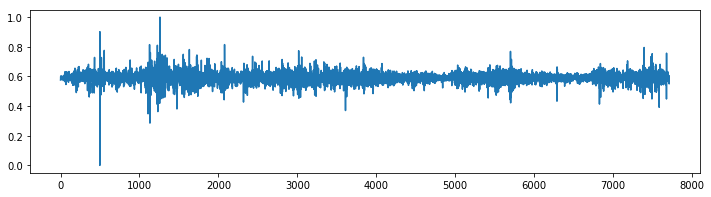

In [7]:
# 日経平均株価の可視化
plt.figure(figsize=(12, 3))
plt.plot(x)

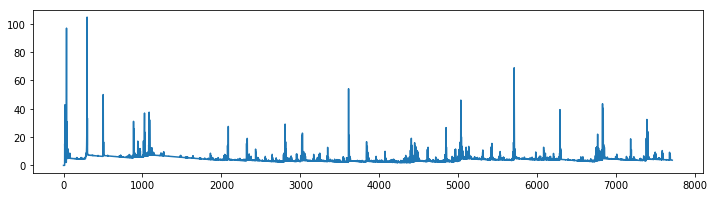

In [8]:
# ChangeFinder 結果(ライブラリ)
plt.figure(figsize=(12, 3))
plt.plot(S_T_L)

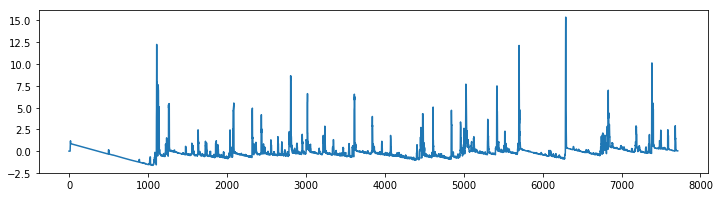

In [9]:
# ChangeFinder 結果(ソースコード)
plt.figure(figsize=(12, 3))
plt.plot(cf_S.S_T)

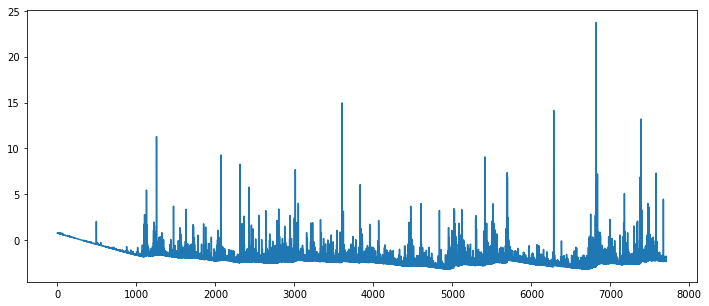

In [10]:
# 第一段階時点の対数損失スコア　ライブラリ
plt.figure(figsize=(12, 5))
plt.plot(cf_L._tmp)

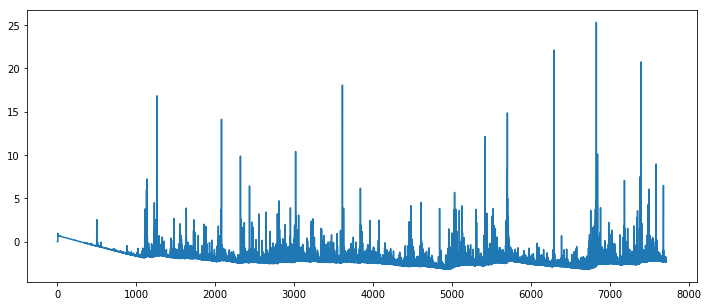

In [11]:
# 第一段階時点の対数損失スコア　ソースコード
plt.figure(figsize=(12, 5))
plt.plot(cf_S.S_X)

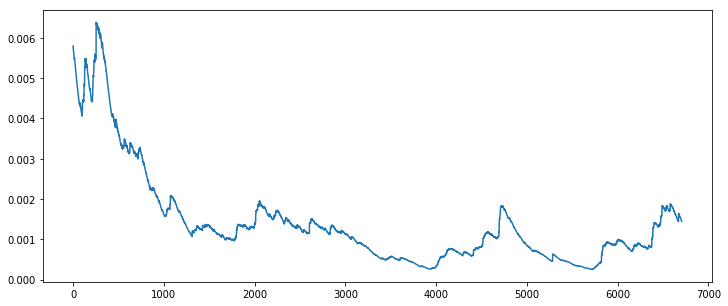

In [12]:
# Σ^ の値 ライブラリ
plt.figure(figsize=(12, 5))
plt.plot(cf_L._sdar_first.tmp_sigma[1000:])

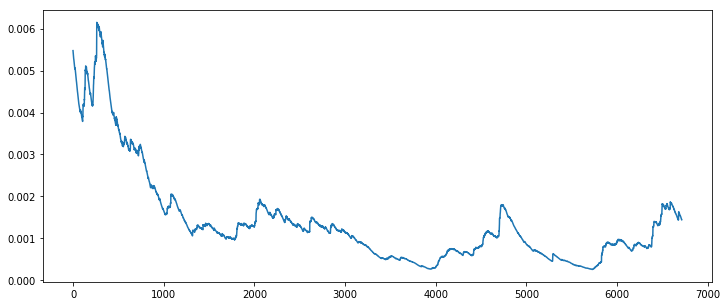

In [13]:
# Σ^ の値 ソースコード
plt.figure(figsize=(12, 5))
plt.plot(cf_S.sdar_f.sigma_hat[1000:])

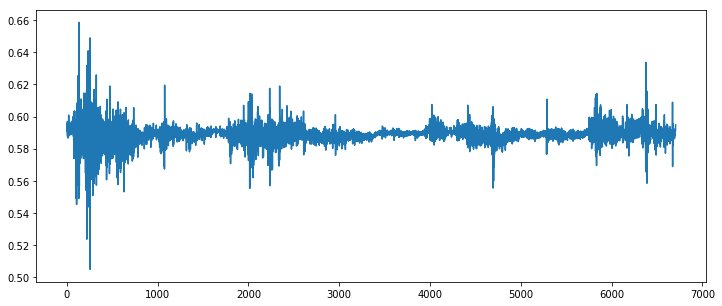

In [14]:
# x_t^の値 ライブラリ
plt.figure(figsize=(12, 5))
plt.plot(cf_L._sdar_first.tmp_xhat[1000:])

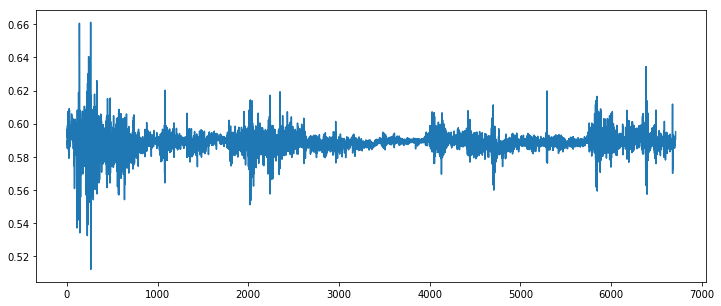

In [15]:
# x_t^の値 ソースコード
plt.figure(figsize=(12, 5))
plt.plot(cf_S.sdar_f.x_t_hat[1000:])

# 平滑化でスケールが変わっている!!!!
np.convolveが原因と思われる

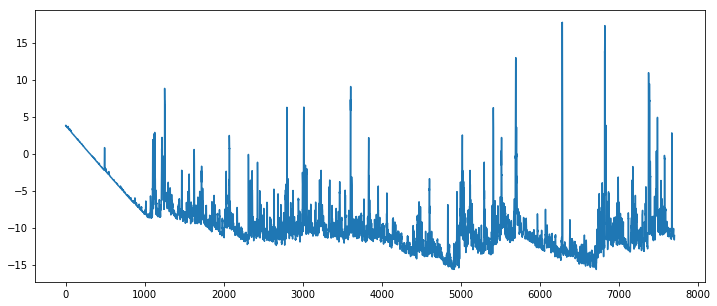

In [16]:
# 平滑化後のスコア　ライブラリ
plt.figure(figsize=(12, 5))
plt.plot(cf_L._tmp_S_X)

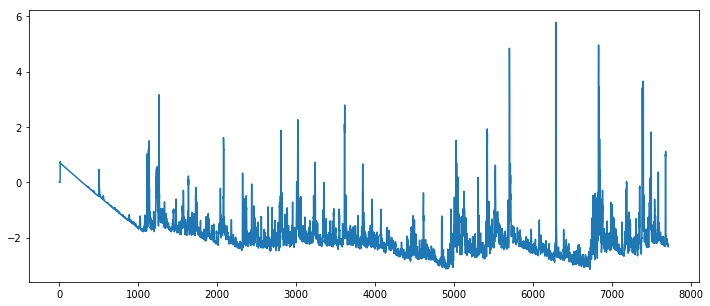

In [17]:
# 平滑化後のスコア　ソースコード
plt.figure(figsize=(12, 5))
plt.plot(cf_S.y)

### 正規分布について
scipy.st.normを使用すると計算がおかしくなる。正規分布を定義した場合、同じような結果となった。

In [18]:
def prob(x_t, xhat, sigma):
    
    p = math.exp(-0.5 *(x_t-xhat)**2/sigma)/((2 * math.pi)**0.5 * sigma**0.5)
    
    return p

In [19]:
import math
prob(1, 0, 1)

0.24197072451914337

In [20]:
import scipy.stats as st

In [21]:
st.norm.pdf(x=1, loc=0, scale=1)

0.24197072451914337

In [22]:
print(cf_S.sdar_f.x[-1])
print(cf_S.sdar_f.x_t_hat[-1], cf_S.sdar_f.sigma_hat[-1])

[0.5843225]
[0.59508451] [0.00144329]


In [23]:
prob(cf_S.sdar_f.x[-1], cf_S.sdar_f.x_t_hat[-1], cf_S.sdar_f.sigma_hat[-1])

array([10.08804914])

In [24]:
st.norm.pdf(x=cf_S.sdar_f.x[-1], loc=cf_S.sdar_f.x_t_hat[-1], scale=cf_S.sdar_f.sigma_hat[-1])

array([2.33402659e-10])

In [25]:
a = [1, 2, 3]
np.convolve(a, 2)

array([2, 4, 6])